In [0]:
#SARIMA model
# Final model

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

Saving Waste_arima.xlsx to Waste_arima.xlsx
User uploaded file "Waste_arima.xlsx" with length 6905 bytes


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



excel_file='Waste_arima.xlsx'
waste_data=pd.read_excel(excel_file, parse_dates=["Date"], index_col="Date")
waste_data.head()

,Food Waste,Plastic Waste,Solid Waste,Total
Date,,,,
2018-01-01,266.5,85.0,0.0,351.5
2018-01-02,216.3,76.6,0.0,292.9
2018-01-03,219.3,98.0,0.0,317.3
2018-01-04,222.7,90.0,2.0,314.7
2018-01-05,220.0,106.5,0.0,326.5


In [0]:
#space after food waste
food=waste_data["Food Waste"]
len(food.values)

30

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


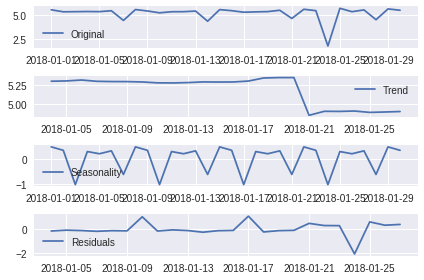

In [0]:
#eliminating trend and seasonality with decomposition 
#makes model stationary

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
food_log = np.log(food)
decomposition = seasonal_decompose(food_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(food_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [0]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# one-step sarima forecast
def sarima_forecast(history, config):
	order, sorder, trend = config
	# define model
	model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
	# fit model
	model_fit = model.fit(disp=False)
	# make one step forecast
	yhat = model_fit.predict(len(history), len(history))
	return yhat[0]

# mean squared error or mse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = sarima_forecast(history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
	result = None
	# convert config to a key
	key = str(cfg)
	# show all warnings and fail on exception if debugging
	if debug:
		result = walk_forward_validation(data, n_test, cfg)
	else:
		# one failure during model validation suggests an unstable config
		try:
			# never show warnings when grid searching, too noisy
			with catch_warnings():
				filterwarnings("ignore")
				result = walk_forward_validation(data, n_test, cfg)
		except:
			error = None
	# check for an interesting result
	if result is not None:
		print(' > Model[%s] %.3f' % (key, result))
	return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
	scores = None
	if parallel:
		# execute configs in parallel
		executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
		tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
		scores = executor(tasks)
	else:
		scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
	# remove empty results
	scores = [r for r in scores if r[1] != None]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
	models = list()
	# define config lists
	p_params = [0, 1, 2]
	d_params = [0, 1]
	q_params = [0, 1, 2]
	t_params = ['n','c','t','ct']
	P_params = [0, 1, 2]
	D_params = [0, 1]
	Q_params = [0, 1, 2]
	m_params = seasonal
	# create config instances
	for p in p_params:
		for d in d_params:
			for q in q_params:
				for t in t_params:
					for P in P_params:
						for D in D_params:
							for Q in Q_params:
								for m in m_params:
									cfg = [(p,d,q), (P,D,Q,m), t]
									models.append(cfg)
	return models

if __name__ == '__main__':
	# define dataset
	#data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
	print(food.values)
	# data split
	n_test = 12
	# model configs
	cfg_list = sarima_configs()
	# grid search
	scores = grid_search(food.values, cfg_list, n_test)
	print('done')
	# list top 3 configs
	for cfg, error in scores[:3]:
		print(cfg, error)

[266.5 216.3 219.3 222.7 220.  241.4  88.  273.8 235.6 194.5 217.5 219.1
 233.5  81.  271.5 243.3 207.2 214.9 220.8 254.1 107.9 281.7 243.5   6.1
 312.2 218.9 263.4  94.9 292.5 254.5]
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'n']] 202.622
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'n']] 188.240
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'n']] 149.020
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'n']] 97.455
 > Model[[(0, 0, 1), (0, 0, 2, 0), 'c']] 72.443
 > Model[[(0, 0, 0), (1, 0, 2, 0), 'n']] 70.577
 > Model[[(0, 0, 0), (2, 0, 0, 0), 'n']] 127.036
 > Model[[(0, 0, 1), (1, 0, 0, 0), 'c']] 68.603
 > Model[[(0, 0, 0), (2, 0, 1, 0), 'n']] 86.713
 > Model[[(0, 0, 1), (1, 0, 1, 0), 'c']] 68.689
 > Model[[(0, 0, 0), (2, 0, 2, 0), 'n']] 69.670
 > Model[[(0, 0, 0), (0, 0, 1, 0), 'c']] 64.089
 > Model[[(0, 0, 0), (0, 0, 2, 0), 'c']] 68.696
 > Model[[(0, 0, 1), (1, 0, 2, 0), 'c']] 74.997
 > Model[[(0, 0, 0), (1, 0, 0, 0), 'c']] 80.439
 > Model[[(0, 0, 1), (2, 0, 0, 0), 'c']] 62.406
 > Model[[(0, 0, 0), (1, 0, 1, 0), 'c']] 63.

In [0]:
#suited config paramaters
print("Best config parameters",scores[0][0])
#porder,psorder,ptrend = list(scores[0][0])


Best config parameters [(1, 0, 1), (2, 0, 0, 0), 'c']


In [0]:
pred_order = (1,0,1)
pred_sorder = (2,0,0,0)
pred_trend = 'c'

#Making right model for predictions
waste_model = SARIMAX(food.values, order=pred_order, seasonal_order=pred_sorder, trend=pred_trend, enforce_stationarity=False, enforce_invertibility=False)
# fit model
waste_model_fit = waste_model.fit(disp=False)
# make one step forecast
predictions = waste_model_fit.predict(len(food.values), len(food.values)+7)
	
print("Next week predictons of food waste ", predictions)

Next week predictons of food waste  [136.01138698 208.12357447 236.80434215 208.61485538 197.335027
 210.87383323 214.24746185 208.25826996]


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
